In [1]:
import numpy as np
import pandas as pd
import distl
from scipy.interpolate import interp1d

In [24]:
def sample_skewed_gaussian(period, period_sigma_low, period_sigma_high, size=1000):
    # generate samples from a (potentially) skewed Gaussian
    samples_low = distl.gaussian(period, period_sigma_low).sample(size)
    samples_high = distl.gaussian(period, period_sigma_high).sample(size)
    
    samples_low_cut = samples_low[samples_low < period]
    samples_high_cut = samples_high[samples_high >= period]
    
    return np.hstack((samples_low_cut, samples_high_cut))

def combine_dists_from_hist(samples1, samples2, bins=1000, plot=False):
    # combine samples from two models and compute new period and uncertainties
    
    samples_full = np.hstack((samples1, samples2))
    hist_combined = distl.histogram_from_data(samples_full, bins=1000)
    
    if plot:
        hist_combined.plot()
        
    uncs = hist_combined.uncertainties()
    return {'period': uncs[1], 
            'period_sigma_low': uncs[1]-uncs[0], 
            'period_sigma_high': uncs[2]-uncs[1],
            'confidence': 1}

def compute_combined_period(lc_ind, results, nsamples = 10000):
    # from 2g and pf to combined periods
    
    period_2g = results['period_2g'][lc_ind]
    period_2g_sigma_low = results['period_2g_sigma_low'][lc_ind]
    period_2g_sigma_high = results['period_2g_sigma_high'][lc_ind]
    
    period_pf = results['period_pf'][lc_ind]
    period_pf_sigma_low = results['period_pf_sigma_low'][lc_ind]
    period_pf_sigma_high = results['period_pf_sigma_high'][lc_ind]
    
    weight_2g = 1./results['chi2_2g'][lc_ind]
    weight_pf = 1./results['chi2_pf'][lc_ind]
    
    print('2g fit: P = %.5f + %.5f - %.5f' % (period_2g, period_2g_sigma_high, period_2g_sigma_low))
    print('pf fit: P = %.5f + %.5f - %.5f' % (period_pf, period_pf_sigma_high, period_pf_sigma_low))
    
    if ~np.isnan(weight_2g) and ~np.isnan(weight_pf):
        wratio = weight_2g/weight_pf

        nsamples_2g = int(wratio*nsamples/(1+wratio))
        nsamples_pf = int(nsamples/(1+wratio))

        print('values check: w_2g = %.6f, w_pf=%.6f, N_2g = %i, N_pf = %i'
         % (weight_2g, weight_pf, nsamples_2g, nsamples_pf))

        samples_2g = sample_skewed_gaussian(period_2g, period_2g_sigma_low, period_2g_sigma_high, size=nsamples_2g)
        samples_pf = sample_skewed_gaussian(period_pf, period_pf_sigma_low, period_pf_sigma_high, size=nsamples_pf)

        combined_result = combine_dists_from_hist(samples_2g, samples_pf, bins=1000, plot=False)
        print(combined_result)
        results['period_combined'][lc_ind] = combined_result['period']
        results['period_combined_sigma_low'][lc_ind] = combined_result['period_sigma_low']
        results['period_combined_sigma_high'][lc_ind] = combined_result['period_sigma_high']

    
    elif np.isnan(weight_2g) and ~np.isnan(weight_pf):
        results['period_combined'][lc_ind] = period_pf
        results['period_combined_sigma_low'][lc_ind] = period_pf_sigma_low
        results['period_combined_sigma_high'][lc_ind] = period_pf_sigma_high
        
    elif ~np.isnan(weight_2g) and np.isnan(weight_pf):
        results['period_combined'][lc_ind] = period_2g
        results['period_combined_sigma_low'][lc_ind] = period_2g_sigma_low
        results['period_combined_sigma_high'][lc_ind] = period_2g_sigma_high
    
    else:
        results['period_combined'][lc_ind] = np.nan 
        results['period_combined_sigma_low'][lc_ind] = np.nan
        results['period_combined_sigma_high'][lc_ind] = np.nan

In [25]:
# def phase_fold_lc(period, t0, times, fluxes, sigmas):
#     t0 = 0 if np.isnan(t0) else t0
#     phases = np.mod((times-t0)/period, 1.0)
#     phases[phases > 0.5] -= 1
    
#     s = np.argsort(phases)

#     return phases[s], fluxes[s], sigmas[s]

# def compute_chi2(lc_ind, chi2_2g, chi2_pf):
    
#     tic = results['TIC'][lc_ind]
#     lc = np.loadtxt('data/lcs_ascii/tic'+f'{tic:010}'+'.norm.lc')
#     phases, fluxes, sigmas = phase_fold_lc(results['period_triage'][lc_ind], 
#                             results['t0_triage'][lc_ind], 
#                             lc[:,0], lc[:,1], lc[:,2])
#     try:
# #     if 1==1:
#         lc_2g = np.loadtxt('data/lcs_2g/tic'+f'{tic:010}'+'.2g.lc')
#         twog_interp = interp1d(lc_2g[:,0], lc_2g[:,1])
#         lc_2g_fluxes = twog_interp(phases)
#         chi2_2g[lc_ind] = np.sum((fluxes-lc_2g_fluxes)**2/sigmas**2)
#     except:
#         chi2_2g[lc_ind] = np.nan
#     try:
#         lc_pf = np.loadtxt('data/lcs_pf/tic'+f'{tic:010}'+'.pf.lc')
#         pf_interp = interp1d(lc_pf[:,0], lc_pf[:,1])
#         lc_pf_fluxes = pf_interp(phases)
#         chi2_pf[lc_ind] = np.sum((fluxes-lc_pf_fluxes)**2/sigmas**2)
#     except:
#         chi2_pf[lc_ind] = np.nan

In [26]:
# results = pd.read_csv("data/full_table.csv")
# chi2_2g, chi2_pf = np.zeros(len(results)), np.zeros(len(results))

# for i in range(len(results)):
#     print(i)
#     compute_chi2(i, chi2_2g, chi2_pf)
# results.insert(37, "chi2_2g", chi2_2g, True)
# results.insert(38, "chi2_pf", chi2_pf, True)
# results.to_csv("data/full_table_chi2.csv")

In [27]:
results = pd.read_csv("data/full_table_chi2.csv")
periods = results[['TIC', 
         'period_2g', 'period_2g_sigma_low', 'period_2g_sigma_high', 'chi2_2g',
        'period_pf', 'period_pf_sigma_low', 'period_pf_sigma_high', 'chi2_pf']]

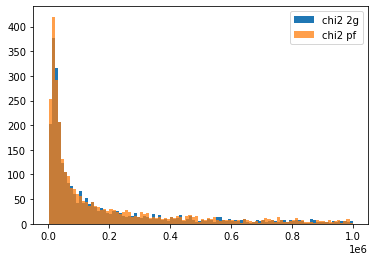

In [44]:
import matplotlib.pyplot as plt
chi2_2g = periods['chi2_2g']
chi2_pf = periods['chi2_pf']
_ = plt.hist(chi2_2g[chi2_2g<1e6], bins=100, label='chi2 2g')
_ = plt.hist(chi2_pf[chi2_pf<1e6], bins=100, label='chi2 pf', alpha=0.75)
plt.legend()
plt.savefig('chi2_dist.png', dpi=300)

In [29]:
periods.insert(9, "period_combined", np.zeros(len(periods)), True)
periods.insert(10, "period_combined_sigma_low", np.zeros(len(periods)), True)
periods.insert(11, "period_combined_sigma_high", np.zeros(len(periods)), True)

In [30]:
for i in range(len(periods)):
    compute_combined_period(i, periods, nsamples = 10000)

2g fit: P = 4.33966 + 0.00094 - 0.00094
pf fit: P = 4.33892 + 0.00003 - 0.00055
values check: w_2g = 0.000072, w_pf=0.000072, N_2g = 4989, N_pf = 5010
{'period': 4.338935259119024, 'period_sigma_low': 0.00045027530395280735, 'period_sigma_high': 0.0011876113228854734, 'confidence': 1}
2g fit: P = nan + 0.00000 - 0.00000
pf fit: P = 1.58059 + 0.00000 - 0.00000
2g fit: P = nan + 0.00000 - 0.00000
pf fit: P = 0.43530 + 0.00000 - 0.00000
2g fit: P = nan + 0.00000 - 0.00000
pf fit: P = 2.94630 + 0.00000 - 0.00000
2g fit: P = 0.89170 + 0.00001 - 0.00001
pf fit: P = 0.89171 + 0.00001 - 0.00001
values check: w_2g = 0.000041, w_pf=0.000042, N_2g = 4917, N_pf = 5082
{'period': 0.8917077698514259, 'period_sigma_low': 1.1911744896342391e-05, 'period_sigma_high': 8.750350760644565e-06, 'confidence': 1}
2g fit: P = 3.85518 + 0.00044 - 0.00041
pf fit: P = 3.85509 + 0.00061 - 0.00079
values check: w_2g = 0.000089, w_pf=0.000086, N_2g = 5105, N_pf = 4894
{'period': 3.855141191960765, 'period_sigma_low'

<ipython-input-24-320d6db5ba30>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['period_combined'][lc_ind] = combined_result['period']
<ipython-input-30-2ed321040a27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compute_combined_period(i, periods, nsamples = 10000)
<ipython-input-24-320d6db5ba30>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['period_combined_sigma_low'][lc_ind] = combined_result['period_sigma_

{'period': 5.728108646292241, 'period_sigma_low': 0.00011863583772253605, 'period_sigma_high': 0.0033818175118707217, 'confidence': 1}
2g fit: P = 0.27128 + 0.00000 - 0.00000
pf fit: P = 0.27128 + 0.00000 - 0.00000
values check: w_2g = 0.000083, w_pf=0.000087, N_2g = 4891, N_pf = 5108
{'period': 0.2712810394267445, 'period_sigma_low': 2.4786212314276135e-06, 'period_sigma_high': 2.3661690600196295e-06, 'confidence': 1}
2g fit: P = nan + 0.00000 - 0.00000
pf fit: P = 2.24653 + 0.00000 - 0.00000
2g fit: P = nan + 0.00000 - 0.00000
pf fit: P = 0.67951 + 0.00000 - 0.00000
values check: w_2g = 0.000000, w_pf=0.000003, N_2g = 10, N_pf = 9989
{'period': 0.6795098827008775, 'period_sigma_low': 1.1022505169711039e-06, 'period_sigma_high': 1.250429686794341e-06, 'confidence': 1}
2g fit: P = 0.53395 + 0.00000 - 0.00000
pf fit: P = 0.53395 + 0.00006 - 0.00002
values check: w_2g = 0.000010, w_pf=0.000010, N_2g = 4937, N_pf = 5062
{'period': 0.5339533668668596, 'period_sigma_low': 1.4343248008641396

<ipython-input-24-320d6db5ba30>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['period_combined'][lc_ind] = period_2g
<ipython-input-24-320d6db5ba30>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['period_combined_sigma_low'][lc_ind] = period_2g_sigma_low
<ipython-input-24-320d6db5ba30>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['period_combined_sigma_high'][lc_ind] = period_2g_sigma_high


{'period': 2.8118320000429464, 'period_sigma_low': 0.004525096499177206, 'period_sigma_high': 0.00499210834422259, 'confidence': 1}
2g fit: P = 0.34917 + 0.00000 - 0.00000
pf fit: P = 0.34917 + 0.00000 - 0.00000
values check: w_2g = 0.000001, w_pf=0.000001, N_2g = 5585, N_pf = 4414
{'period': 0.34917280409165735, 'period_sigma_low': 5.686591049713918e-07, 'period_sigma_high': 2.68629575483903e-06, 'confidence': 1}
2g fit: P = 4.43300 + 0.00007 - 0.00007
pf fit: P = 4.43320 + 0.00003 - 0.00004
values check: w_2g = 0.000014, w_pf=0.000017, N_2g = 4468, N_pf = 5531
{'period': 4.433147058679627, 'period_sigma_low': 0.00017429269770641298, 'period_sigma_high': 7.362311802516786e-05, 'confidence': 1}
2g fit: P = 0.51262 + 0.00000 - 0.00000
pf fit: P = 0.51262 + 0.00000 - 0.00000
values check: w_2g = 0.000005, w_pf=0.000004, N_2g = 5251, N_pf = 4748
{'period': 0.5126226016542772, 'period_sigma_low': 2.098052085064417e-06, 'period_sigma_high': 1.8743095121509512e-06, 'confidence': 1}
2g fit: P

/Users/angela/miniconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


{'period': 9.490202378865341, 'period_sigma_low': 0.00012588678245428753, 'period_sigma_high': 5.9764380745619405e-05, 'confidence': 1}
2g fit: P = 2.70358 + 0.00001 - 0.00001
pf fit: P = 2.70109 + 0.00002 - 0.00000
values check: w_2g = 0.000000, w_pf=0.000000, N_2g = 4897, N_pf = 5102
{'period': 2.7011380176473088, 'period_sigma_low': 4.963214246256342e-05, 'period_sigma_high': 0.0024481081785143743, 'confidence': 1}
2g fit: P = 5.55412 + 0.00013 - 0.00013
pf fit: P = 5.55427 + 0.00016 - 0.00016
values check: w_2g = 0.000041, w_pf=0.000059, N_2g = 4076, N_pf = 5923
{'period': 5.55420026477955, 'period_sigma_low': 0.00015749335797909936, 'period_sigma_high': 0.00017287967732837473, 'confidence': 1}
2g fit: P = 1.74333 + 0.00012 - 0.00036
pf fit: P = 1.74250 + 0.00075 - 0.00000
values check: w_2g = 0.000086, w_pf=0.000080, N_2g = 5180, N_pf = 4819
{'period': 1.743248592902523, 'period_sigma_low': 0.000427137008291556, 'period_sigma_high': 0.00020385240756715106, 'confidence': 1}
2g fit:

In [23]:
periods

,TIC,period_2g,period_2g_sigma_low,period_2g_sigma_high,chi2_2g,period_pf,period_pf_sigma_low,period_pf_sigma_high,chi2_pf,period_combined,period_combined_sigma_low,period_combined_sigma_high
0,86081744,4.339664,9.381000e-04,9.361500e-04,1.389388e+04,4.338916,5.492500e-04,2.548000e-05,1.383528e+04,4.338935,4.480905e-04,1.171438e-03
1,13351941,NaN,8.600000e-07,8.700000e-07,NaN,1.580593,2.700000e-07,3.100000e-07,2.085351e+07,1.580593,2.700000e-07,3.100000e-07
2,79403459,NaN,1.500000e-07,1.500000e-07,NaN,0.435305,1.000000e-07,1.100000e-07,1.475171e+07,0.435305,1.000000e-07,1.100000e-07
3,119461266,NaN,1.790000e-06,1.850000e-06,NaN,2.946297,1.670000e-06,1.670000e-06,4.010785e+07,2.946297,1.670000e-06,1.670000e-06
4,28763683,0.891701,1.154000e-05,1.107000e-05,2.441234e+04,0.891711,6.000000e-06,7.230000e-06,2.361614e+04,0.891708,1.224481e-05,8.659431e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
4764,394230860,28.964913,4.290000e-06,4.760000e-06,2.485355e+05,28.964892,8.259000e-05,5.464000e-05,1.225657e+07,28.964913,4.504772e-06,4.959938e-06
4765,100508429,2.953118,1.357000e-05,1.497000e-05,3.126167e+05,2.953034,5.060000e-06,7.843000e-05,3.105914e+05,2.953106,7.461348e-05,2.510707e-05
4766,79328890,0.744029,3.990000e-06,4.240000e-06,1.903316e+06,0.744120,8.151000e-05,6.197000e-05,9.156191e+05,0.744067,4.129588e-05,9.612109e-05
4767,375422201,NaN,4.372000e-05,2.681000e-05,2.628763e+08,4.076692,0.000000e+00,3.380000e-06,1.627337e+08,4.076694,1.617814e-06,2.383395e-06


In [41]:
periods.to_csv('tess_periods_combined.csv', na_rep='NaN', float_format='%.8f')